## Описание проекта <a class="tocSkip">
    
Оптимизация расходов электроэнергии путем предсказания температуры расплава. Исходные данные взяты из реального процесса выплавки стали на металлургическом комббинае и содержат информацию о температуре расплава (измеряемую в разные моменты времкени), данные о внесении примесей (тип примеси и время внесения), данные о нагрева (время начала и конца нагрева, активная и реактивная мощности).

## План работ <a class="tocSkip">
    
1. Исследовательский анализ данных  
   1.1. Импорт библиотек и данных  
   1.2. Первичный анализ датасетов   
   1.3. Удаление пропусков и исключение избыточных данных    
   1.4. Подготовка данных для обучения  
2. Обучение модели  
   2.1. Расчет метрики MAE для наивного регрессора  
   2.2. Выбор оптимальной модели для предсказаний температуры  
   2.3. Расчет метрики MAE и R2 для наилучшей модели на тестовой выборке   
   2.4. Анализ результатов для наилучшей модели    
3. Отчет (модель)    
   3.1. Представление результатов
   3.2. Подготовка данных к йфинальному отчету

## Краткое содержание работ по плану <a class="tocSkip">

***1. Исследовательский анализ данных***    

   *1.1. Импорт библиотек и данных*     
   Импорт библиотек необходимых для обработки данных, построения графиков и машинного обучения. Импорт данных.  
   
   *1.2. Первичный анализ датасетов*     
   Первичный анализ данных, выявление наличия пропусков в данных. 
   
   *1.3. Удаление пропусков и исключение избыточных данных*  
   Удаление пропусков (при необходимости), создание датасетов с которыми в дальнейшем будет идти работа (исходные датасеты останутся неизменными).    
   
   *1.4. Подготовка данных для обучения*  
   Сведение признаков в один датасет. Подготовка тренировочной, валидационной и тестовой выборок. Дескриптивная статистика по всем данным.   

***2. Обучение модели***    

   *2.1. Расчет метрики MAE для наивного регрессора*  
   Расчет метрики MAE для наивного регрессора, как референтного значения с целью последующего сравнения с данными предсказательных моделей.  
   
   *2.2. Выбор оптимальной модели для предсказаний температуры*  
   Выбор модели для предсказаний: линейная регрессия, случайный лес, модели градиентного бустинга. Расчет метрик MAE и R2 на валидационной выборке.
   
   *2.3. Расчет метрики MAE для наилучшей модели на тестовой выборке*  
   Расчет метрик MAE и R2 для наилучшей модели на тестовой выборке и сравнение с референтным значением
   
   *2.4. Анализ результатов для наилучшей модели*  
   Анализ полученных результатов и возможные пути улучшения предсказаний  

***3. Отчет***  
Выводы по полученным результатам. Рекомендации для бизнеса по возможныцм способам улучшения контроля температуры и уменьшению расхода электроэнергии. Построение графиков для презентации заказчику.

## Исследовательский анализ данных

### Импорт библиотек и данных

In [1]:
#импорт библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.ticker
import random
import warnings
from pandas.plotting import register_matplotlib_converters
from scipy import stats as st

In [2]:
#импорт функций для анализа данных
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import catboost as cb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression

In [3]:
#импорт данных об электродах
data_arc = pd.read_csv('/datasets/data_arc.csv')

In [4]:
#импорт данных о подаче сыпучих материалов (объём)
data_bulk = pd.read_csv('/datasets/data_bulk.csv')

In [5]:
#импорт данных о подаче сыпучих материалов (время)
data_bulk_time = pd.read_csv('/datasets/data_bulk_time.csv')

In [6]:
#импорт data_gas.csv — данные о продувке сплава газом
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [7]:
#импорт результатов измерения температуры
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [8]:
#импорт данных о проволочных материалах (объём)
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [9]:
#импорт данных о проволочных материалах (время)
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Первичный анализ датасетов

In [10]:
#вывод общей информации
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в данных нет

In [11]:
#вывод общей информации
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В данных сдержатся пропуски, необходимо выяснить их причину: является ли это особенностью записи информации о технологическом процесса или недостаток информации 

In [12]:
#вывод общей информации
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В данных содержатся пропуски, которые соответствуют пропускам в датасете `data_bulk`

В данных содержатся даты и времена, поэтому не будем рассчитывать для них статиститку. 

In [13]:
#вывод общей информации
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В данных нет пропусков

In [14]:
#вывод общей информации
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В колонке `Температура` содержатся пропуски.

In [15]:
#вывод общей информации
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В данных есть пропуски. 

In [16]:
#вывод общей информации
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Изучим датасеты, `data_bulk`, `data_bulk_time`, `data_wire`, `data_wire_temp` и `data_temp`, содержащие пропуски.

### Удаление пропусков и исключение избыточных данных

In [17]:
#вывод данных
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Как видно из данных, пропуски в `data_bulk` соответствуют отсутствию добавления сыпучих материалов. Эти пропуски можно заменить на нулевые значения.  

In [18]:
#вывод данных
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как видно из данных, пропуски в `data_wire` соответствуют отсутствию добавления проволочных материалов. Эти пропуски можно заменить на нулевые значения.  

***Замена NaN на нулевые значения для `data_bulk` и `data_wire`***

In [19]:
#замена нулевых значений
data_bulk2 = data_bulk.fillna(0).copy(deep = True)
data_wire2 = data_wire.fillna(0).copy(deep = True)

In [20]:
#проверка замены пропусков на нулевые значения
data_bulk2
#data_wire2

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [21]:
#вывод данных
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


В данной таблице указана дата и время добавления примеси, что не влияет на температуры смеси, поэтму эти данные можно исклбючить из рассмотрения при построении предсказательной модели. 

In [22]:
#вывод данных
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В данной таблице указана дата и время добавления примеси, что не влияет на температуры смеси, поэтму эти данные можно исключить из рассмотрения при построении предсказательной модели. 

In [23]:
#вывод данных
data_temp2 = data_temp.copy(deep = True)

Как видно из данных замеры температуры проводились несколько раз в течение всего процесса выплавки. Поскольку ненобходимо предсказывать температуры, то удалим все строки с пропусками, а отрицательные значения температуры заменим на средние значения. 

In [24]:
#удаление пропусков 
data_temp2 = data_temp2.dropna(axis = 0).reset_index(drop = True)

#поиск отрицательныцх температур
print('Число данных с отрицательной температурой', len(data_temp2.loc[data_temp2.loc[:,'Температура'] < 0]))

#вывод обновленного датасета
data_temp2

Число данных с отрицательной температурой 0


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0
13002,3238,2019-08-31 23:30:31,1584.0
13003,3239,2019-09-01 01:31:47,1598.0
13004,3240,2019-09-01 02:39:01,1617.0


In [25]:
#создание коппи датасета с копией data_gas
data_gas2 = data_gas.copy(deep = True)

***Поиск аномальных значений параметров***

При обработке данных необходимо учитывать, что значения данных не могут быть отрицательными. Поэтому проведем поиск отрицательных значений и удалим их. 

In [26]:
#создание копии датасета
data_arc2 = data_arc.copy(deep = True)

data_arc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [27]:
data_arc2 = data_arc2.loc[(data_arc2.loc[:,'Активная мощность'] > 0) &\
                          (data_arc2.loc[:,'Реактивная мощность'] > 0)]

In [28]:
data_arc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
key                     14875 non-null int64
Начало нагрева дугой    14875 non-null object
Конец нагрева дугой     14875 non-null object
Активная мощность       14875 non-null float64
Реактивная мощность     14875 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.3+ KB


В датасете было лишь одно отрицательное значение.

###  Подготовка данных для обучения

#### Выделение признаков и целевого признака

Для построения предсказательной модели ненобходимо отобрать признаки и целевой признак. 
Целевой признак - последний замер температуры в датасете `data_temp`. При этом количество записей температуры должно быть не меньше двух: начальная температура партии и конечная температура партии (целевой признак).

При отборе признаков будем учитывать, что некоторые из них могут быть избыточными и будут ухудшать значения целевой метрики. Поэтому более детально проанализируем датасеты с целью создания признаков. 

При построении предсказательной модели, не будем использовать взаимосвязь между временами введения примесей, временами продувки газа и конкретными временами начала и конца нагрева. Это обусловлено тем, что в ходе выплавления стали протекают различные физико-химические процессы, имеющие сложную взаимосвязь друг с другом, и зависящие от скорости введения добавок, их объема и равномерности введения в расплав, времени нагрева и скорости нагрева, зависящей как от объема материала, так и от его физико-химических свойств. Т.е. мы отказываемся от учета кинетики процесса, и будем строить предсказательную модель опирающуюся на интегральные показатели: объемы вводимых добавок и суммарную затрачиваемую энергию. 

В свзяи с вышесказанным из показаний температуры мы оставим только начальную и конечные температуры и суммарную затрачиваемую энергию.

#### Суммарная затрачиваемая энергия

Полная мощность $P$ рассчитывается из активной $P_{a}$ и реактивной мощностей $P_{r}$, приведенных в таблице `data_arc` как:  

$$P = \sqrt(P_{a} + P_{r})$$

Суммарная затрачиваемая энергия $E$ рассчитывается из $P$ следующим образом:

$$E = \sum_{i}(E_{i}) = \sum_{i}(Pt_{i}),$$

где $E_{i}$ - энергия, затрачиваемая на один цикл нагрева, $t_{i}$ время одного цикла нагрева, $i$ - номер цикла нагрева.

Для расчета полной затрачиваемой энергии, преобразуем временной тип данных в `data_arc` и рассчитаем длительность интервалов нагрева.

In [29]:
#преобразование типа данных
data_arc2['Начало нагрева дугой'] = data_arc2['Начало нагрева дугой'].astype('datetime64[ns]')
data_arc2['Конец нагрева дугой'] = data_arc2['Конец нагрева дугой'].astype('datetime64[ns]')

#проверка конвертации
data_arc2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
key                     14875 non-null int64
Начало нагрева дугой    14875 non-null datetime64[ns]
Конец нагрева дугой     14875 non-null datetime64[ns]
Активная мощность       14875 non-null float64
Реактивная мощность     14875 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


In [30]:
#вычисление времени нагрева и времени нагрева в секундах
data_arc2['heat_time'] = data_arc2['Конец нагрева дугой'] - data_arc2['Начало нагрева дугой']
data_arc2['heat_time_sec'] = (data_arc2['Конец нагрева дугой'] - data_arc2['Начало нагрева дугой']).\
                        dt.total_seconds()

#проверка расчета
data_arc2

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_time,heat_time_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,148.0
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,00:02:37,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,00:03:00,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,00:03:04,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,00:00:57,57.0


In [31]:
#расчет полной энергии затрачиваемой в одном цикле нагрева
data_arc2['E_i'] = data_arc2['heat_time_sec'] * \
                  np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

#расчет полной активной  и реактивной энергий затрачиваемой в одном цикле нагрева
data_arc2['E_ia'] = data_arc2['heat_time_sec'] * data_arc2['Активная мощность']
data_arc2['E_ir'] = data_arc2['heat_time_sec'] * data_arc2['Реактивная мощность']

In [32]:
data_arc2

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_time,heat_time_sec,E_i,E_ia,E_ir
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,228.0,272.149755,222.541395,156.655088
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,185.0,177.416785,149.037310,96.252771
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,172.0,154.118502,128.030509,85.794529
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,365.0,719.221394,605.667332,387.874330
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,148.0,119.471318,102.527702,61.330791
...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,00:02:37,157.0,100.581755,83.786125,55.646875
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,00:03:00,180.0,154.000682,121.788672,94.253538
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,00:03:04,184.0,160.919002,135.037503,87.520271
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,00:00:57,57.0,15.075853,12.579555,8.308799


In [33]:
#подсчет суммарной затраченной энергии
data_energy = data_arc2.pivot_table(values = ['heat_time_sec', 'E_i', 'E_ia', 'E_ir'], \
                                    index = 'key', aggfunc = ['sum'])

#сброс индексов и переимнование столбцов
data_energy = data_energy.reset_index()
data_energy.columns = ['key', 'heat_time', 'Total_Energy', 'Total_ActiveEnergy', 'Total_ReactiveEnergy']

#вывод данных
data_energy

,key,heat_time,Total_Energy,Total_ActiveEnergy,Total_ReactiveEnergy
0,1,1442.377754,1207.804249,787.907510,1098.0
1,2,881.233565,733.816470,487.590677,811.0
2,3,525.066777,443.583327,280.936835,655.0
3,4,796.911309,670.663327,429.935932,741.0
4,5,1199.137958,997.496095,664.940090,869.0
...,...,...,...,...,...
3209,3237,958.336236,777.993447,559.334413,909.0
3210,3238,555.867370,432.849310,348.343323,546.0
3211,3239,1013.067719,844.977151,557.964769,1216.0
3212,3240,729.208940,554.283211,471.603883,839.0


Теперь полученные значения энергий можно использовать как признак. 

#### Выделение начальной и конечной температур

In [34]:
#приведение даты к типу datetime
data_temp2['Время замера'] = data_temp2['Время замера'].astype('datetime64[ns]')

#проверка замены типа
data_temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 305.0 KB


In [35]:
data_temp2

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0
13002,3238,2019-08-31 23:30:31,1584.0
13003,3239,2019-09-01 01:31:47,1598.0
13004,3240,2019-09-01 02:39:01,1617.0


In [36]:
#создание сводной таблицы с аггрегацией по ключи и выбором первого и последнего значения 
#для соответствующего ключа и подсчетом полного количесива записей для каждого ключа
data_temp_pivot = data_temp2.pivot_table(values = 'Температура', index = 'key',\
                                         aggfunc = ['first', 'last', 'count'])

#сброс индексов и переимнование столбцов
data_temp_pivot = data_temp_pivot.reset_index()
data_temp_pivot.columns = ['key', 'Initial_T', 'Final_T', 'count']

#вывод сводной таблицы
data_temp_pivot

,key,Initial_T,Final_T,count
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
...,...,...,...,...
3211,3237,1569.0,1569.0,1
3212,3238,1584.0,1584.0,1
3213,3239,1598.0,1598.0,1
3214,3240,1617.0,1617.0,1


Теперь избавимся от рядов (партий) для которых есть только одна запись температуры.

In [37]:
data_temp_pivot = data_temp_pivot.loc[data_temp_pivot.loc[:,'count'] > 1]

data_temp_pivot

,key,Initial_T,Final_T,count
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
...,...,...,...,...
2472,2495,1570.0,1591.0,3
2473,2496,1554.0,1591.0,4
2474,2497,1571.0,1589.0,2
2475,2498,1591.0,1594.0,5


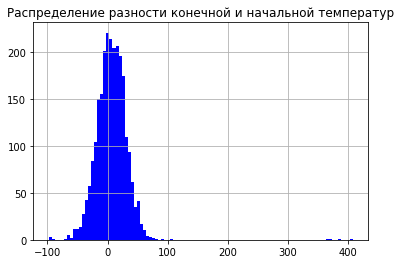

In [38]:
#построим график распределения разности температур
(data_temp_pivot['Final_T'] - data_temp_pivot['Initial_T']).hist(bins = 100, color = 'blue');
plt.title('Распределение разности конечной и начальной температур');

Из гистограммы видно, что есть выпадающие значения, т.е. записи для которых разностей конечной и начальной температуры выше (по абсолютному значению более, чем на 100 градусов). Удалим такие значения из рассмотрения. 

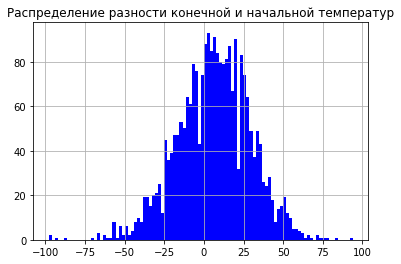

In [39]:
data_temp_pivot = data_temp_pivot.loc\
                  [(data_temp_pivot.loc[:,'Final_T'] - data_temp_pivot.loc[:,'Initial_T'])\
                  < 100]

#построим график распределения разности температур дял проверки
(data_temp_pivot['Final_T'] - data_temp_pivot['Initial_T']).hist(bins = 100, color = 'blue');
plt.title('Распределение разности конечной и начальной температур');

После удаления выпадающих значений все разности температур лежат в диапазоне +- 100 градусов. 

In [40]:
data_temp_pivot

,key,Initial_T,Final_T,count
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2
...,...,...,...,...
2472,2495,1570.0,1591.0,3
2473,2496,1554.0,1591.0,4
2474,2497,1571.0,1589.0,2
2475,2498,1591.0,1594.0,5


#### Выделение числа засыпей примесей

In [41]:
#создание списка колонок
columns = data_bulk.columns.to_list()

#исключие колонки 'key'
columns.pop(0)

'key'

In [42]:
#подсчет числа засыпей сыпучих примесей
data_bulk2['count_bulk'] = data_bulk2[columns].gt(0).sum(axis = 1)

In [43]:
#создание списка колонок
columns = data_wire.columns.to_list()

#исключие колонки 'key'
columns.pop(0)

'key'

In [44]:
#подсчет числа засыпей проволочных материалов
data_wire2['count_wire'] = data_wire2[columns].gt(0).sum(axis = 1)

In [45]:
#подсчет числа циклов нагрева
#data_arc_count = data_arc2.groupby('key').count().reset_index()

#добавление числа циклов нагрева к датасету 'data_energy'
#data_energy['count_T'] = data_arc_count['heat_time']

#вывод данных
#data_energy

#### Объединение признаков и целевого признака в единый датасет

Для получения датасета, содержащего признаки и целевой признак, объединим датасеты
* `data_energy`
* `data_temp_pivot`
* `data_bulk2`
* `data_wire2`
* `data_gas2`

Объединение датасетов будем производить по столбцу `key`. 

In [46]:
#создание списка с датафреймами
data_list = [data_temp_pivot, data_energy, data_bulk2, data_wire2, data_gas2]

In [47]:
#обединение датасетов
data_joined = pd.concat([x.set_index('key') for x in data_list], axis=1, join='inner')

data_joined

,Initial_T,Final_T,count,heat_time,Total_Energy,Total_ActiveEnergy,Total_ReactiveEnergy,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,count_wire,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,1442.377754,1207.804249,787.907510,1098.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,29.749986
2,1581.0,1602.0,6,881.233565,733.816470,487.590677,811.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,12.555561
3,1596.0,1599.0,5,525.066777,443.583327,280.936835,655.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,28.554793
4,1601.0,1625.0,3,796.911309,670.663327,429.935932,741.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,18.841219
5,1576.0,1602.0,2,1199.137958,997.496095,664.940090,869.0,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3,778.818234,626.167357,462.572488,723.0,0.0,0.0,21.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7.125735
2496,1554.0,1591.0,4,875.261419,727.868032,485.842067,940.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9.412616
2497,1571.0,1589.0,2,556.930349,427.535518,356.837023,569.0,0.0,0.0,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,6.271699


In [48]:
data_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 34 columns):
Initial_T               2325 non-null float64
Final_T                 2325 non-null float64
count                   2325 non-null int64
heat_time               2325 non-null float64
Total_Energy            2325 non-null float64
Total_ActiveEnergy      2325 non-null float64
Total_ReactiveEnergy    2325 non-null float64
Bulk 1                  2325 non-null float64
Bulk 2                  2325 non-null float64
Bulk 3                  2325 non-null float64
Bulk 4                  2325 non-null float64
Bulk 5                  2325 non-null float64
Bulk 6                  2325 non-null float64
Bulk 7                  2325 non-null float64
Bulk 8                  2325 non-null float64
Bulk 9                  2325 non-null float64
Bulk 10                 2325 non-null float64
Bulk 11                 2325 non-null float64
Bulk 12                 2325 non-null float64
Bulk 13              

Рассчитаем дескриптивную статистику для всего датасета. 

In [49]:
#data_joined = data_joined.loc[(data_joined.loc[:,'Final_T'] > 1560) &\
#                              (data_joined.loc[:,'Final_T'] < 1625)]

In [50]:
#расчет интерквартильного размаха
iqr = data_joined['Final_T'].describe()[6] - data_joined['Final_T'].describe()[4]

#расчет нижней границы температуры
range_low = data_joined['Final_T'].describe()[4] - 3 * iqr

#расчет верхней границы температуры
range_high = data_joined['Final_T'].describe()[6] + 3 * iqr

In [51]:
#вывод диапазона температур
print('Нижний предел температуры', range_low)
print('Верхний предел температуры', range_high)

Нижний предел температуры 1554.0
Верхний предел температуры 1631.0


Диапазон температур слегка изменился по сравнению с прежними оценками.

In [52]:
#исключение аномальных значений температур из рассмотрения
data_joined = data_joined.loc[(data_joined.loc[:,'Final_T'] > range_low) &\
                              (data_joined.loc[:,'Final_T'] < range_high)]

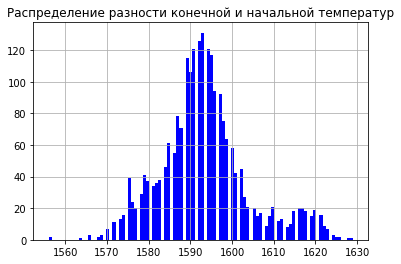

In [53]:
#построим график распределения разности температур
data_joined['Final_T'].hist(bins = 100, color = 'blue');
plt.title('Распределение разности конечной и начальной температур');

На гистограмме температур видны значения сильно отступающие от других значений температур. Можно полагать, что это также аномальные выбросы. Посчитаем сколько таких выбросов (записей с температурой меньше 1560 градусов) и если их мало исключим их из рассмотрения.

In [54]:
#выделение температур ниже 1560
data_q = data_joined.loc[data_joined.loc[:,'Final_T'] <= 1560]
data_q

,Initial_T,Final_T,count,heat_time,Total_Energy,Total_ActiveEnergy,Total_ReactiveEnergy,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,count_wire,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1362,1546.0,1556.0,7,415.908306,308.845714,278.528741,654.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1,6.170417
2109,1619.0,1556.0,9,538.786301,414.495159,343.939177,814.0,34.0,258.0,0.0,...,0.0,93.117027,43.244242,0.0,73.170247,0.0,0.0,0.0,4,17.790213


Из данных видно, что таких температур всего две и они лежат близко к границам экстремальных выбросов. Исключим их из рассмотрения.

In [55]:
#исключение аномальных значений температур из рассмотрения
data_joined = data_joined.loc[data_joined.loc[:,'Final_T'] > 1560]

In [56]:
data_joined.describe()

,Initial_T,Final_T,count,heat_time,Total_Energy,Total_ActiveEnergy,Total_ReactiveEnergy,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,count_wire,Газ 1
count,2311.000000,2311.000000,2311.000000,2311.000000,2311.000000,2311.000000,2311.000000,2311.00000,2311.000000,2311.000000,...,2311.000000,2311.000000,2311.000000,2311.0,2311.000000,2311.0,2311.000000,2311.000000,2311.000000,2311.000000
mean,1587.229338,1593.434444,4.962787,902.165275,720.382005,539.713435,806.716140,3.33016,0.671571,47.537430,...,17.712292,3.016026,0.075449,0.0,0.761604,0.0,0.313736,0.319583,1.389009,11.331806
std,23.420626,10.658814,1.760657,648.450203,520.229745,389.156970,338.925654,12.21930,13.257322,75.362134,...,33.716699,27.665453,1.851344,0.0,7.697636,0.0,4.419741,3.469888,0.539874,6.287686
min,1519.000000,1564.000000,2.000000,15.158096,10.614857,10.127814,57.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.008399
25%,1571.000000,1587.000000,4.000000,465.266815,372.415455,276.884063,581.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,7.274879
50%,1587.000000,1593.000000,5.000000,767.825640,610.123660,458.550936,777.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,10.088416
75%,1603.000000,1598.000000,6.000000,1165.524923,928.087295,695.030504,992.500000,0.00000,0.000000,80.000000,...,23.156640,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.000000,14.183340
max,1660.000000,1629.000000,16.000000,10630.980668,8624.443403,6210.257223,4189.000000,185.00000,325.000000,454.000000,...,282.780152,385.008668,58.046562,0.0,180.454575,0.0,102.762401,62.025600,4.000000,77.995040


#### Исследование мультиколлинеарности

Исследуем мультиколлинераность на датасете, содержащем только признаки.

In [57]:
#выделение признаков
features = data_joined.drop(['Final_T'], axis = 1).copy(deep = True)

#рассчитаем матрицу парных корреляций
matrix = features.corr('pearson').to_numpy()

In [58]:
#построение матрицы парных корреляций
def PlotCorrelationMatrix(matrix):
  
    #построение матрицы парных корреляций
    fig, axes = plt.subplots(1, 1, figsize=(12,8))
    plt.suptitle('Матрица парных корреляций');
    
    image = axes.imshow(pd.DataFrame(matrix), vmin = -0.6, vmax = 1, cmap="Accent")
    
    axes.set_xlabel('номер колонки')
    axes.set_ylabel('номер колонки')
    plt.colorbar(image)

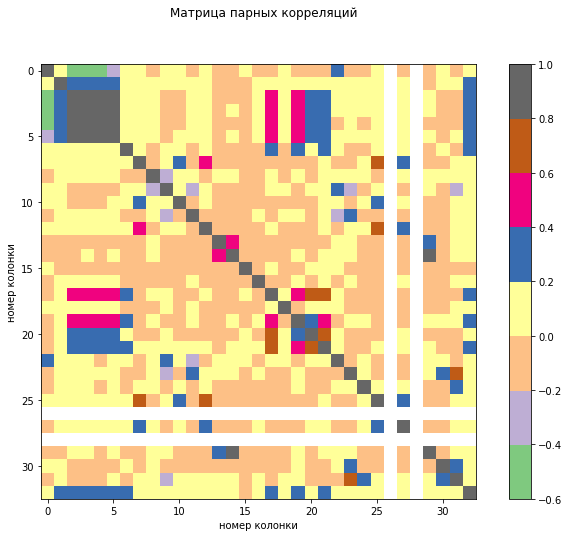

In [59]:
#визуализация матрицы парных корреляций
PlotCorrelationMatrix(matrix)

Визуальный анализ графического представления матрицы парных корреляций показывает, что существует некоторое количество колонок, значения в которых сильно коррелированны друг с другом. При этом степень корреляция высока - почти единица. Уберем из рассмотрения все колонки, коэффициент корреляции между которыми превышает критический. В качестве порога - возбьем величину равную 0.6. 

Также на графике матрицы парных корреляций есть белые полосы. Исследуем этот вопрос подробнее.

In [60]:
#преобразуем матрицу в датафрейм для удобства анализа
matrixdf = pd.DataFrame(matrix, index = features.columns, columns = features.columns)
matrixdf

,Initial_T,count,heat_time,Total_Energy,Total_ActiveEnergy,Total_ReactiveEnergy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,count_wire,Газ 1
Initial_T,1.000000,0.184639,-0.428644,-0.430921,-0.418545,-0.399224,0.064264,0.096832,-0.110758,0.161573,...,-0.099231,-0.019581,0.080616,NaN,-0.032500,NaN,-0.029756,0.003218,-0.088269,0.018939
count,0.184639,1.000000,0.261141,0.257394,0.263397,0.385130,0.089469,0.054948,0.029902,0.005054,...,0.056036,0.071690,0.031122,NaN,0.014238,NaN,-0.008935,0.001249,0.028444,0.307837
heat_time,-0.428644,0.261141,1.000000,0.996995,0.992711,0.899981,0.062022,0.006348,0.063230,-0.039701,...,0.017345,0.001190,0.015767,NaN,0.035244,NaN,0.001104,-0.012294,-0.010951,0.319829
Total_Energy,-0.430921,0.257394,0.996995,1.000000,0.980516,0.894828,0.056579,0.005320,0.073239,-0.038859,...,0.017781,0.003438,0.014920,NaN,0.037898,NaN,0.003638,-0.012750,-0.007811,0.321050
Total_ActiveEnergy,-0.418545,0.263397,0.992711,0.980516,1.000000,0.896928,0.071456,0.008458,0.045746,-0.040243,...,0.016047,-0.002441,0.017421,NaN,0.030378,NaN,-0.003684,-0.011373,-0.016268,0.314582
Total_ReactiveEnergy,-0.399224,0.385130,0.899981,0.894828,0.896928,1.000000,0.093828,0.007843,0.094345,-0.032747,...,0.057256,0.025203,0.020184,NaN,0.027570,NaN,0.018241,-0.011443,0.014437,0.396068
Bulk 1,0.064264,0.089469,0.062022,0.056579,0.071456,0.093828,1.000000,0.155725,-0.006192,0.036498,...,-0.004940,-0.000753,0.098682,NaN,0.084305,NaN,-0.019354,0.012020,-0.007337,0.213408
Bulk 2,0.096832,0.054948,0.006348,0.005320,0.008458,0.007843,0.155725,1.000000,-0.031967,0.022286,...,-0.026623,0.164586,0.760899,NaN,0.362505,NaN,-0.003597,-0.004668,0.132113,0.145281
Bulk 3,-0.110758,0.029902,0.063230,0.073239,0.045746,0.094345,-0.006192,-0.031967,1.000000,-0.294972,...,0.093544,0.011151,-0.025718,NaN,0.026200,NaN,0.004683,0.004404,0.068244,0.065972
Bulk 4,0.161573,0.005054,-0.039701,-0.038859,-0.040243,-0.032747,0.036498,0.022286,-0.294972,1.000000,...,-0.267962,-0.046284,0.020704,NaN,-0.032855,NaN,0.007957,-0.058207,-0.243313,0.010256


 Из матрицы парных корреляций становится понятно, что все значения в колонке `Wire 5` и `Wire 7`  нулевые. Это подтверждается дескритивной статистикой, рассчитанной в предыдущем разделе! Таким образом, все значения признаков `Wire 5` и `Wire 7` нулевые, а значит их необходимо удалить. 

In [61]:
#удаление колонки Wire 5
features = features.drop(['Wire 5', 'Wire 7'], axis = 1)

Теперь в автоматическом режиме пройдем по матрице корреляций и удалим колонки для которых значений коэффициента корреляции превышает критический.

In [62]:
#функция для выявления корреляций в строке для заданного ряда в корреляционной матрице
def CheckCorrelation(first, line_j, del_list, columns_list, correlation_matrix, threshold):
  
    last = correlation_matrix.shape[0]
    s = 0

    for i in range(first, last):  #проход вдоль ряда, для поиска значений превышающих пороговое
        
        if line_j != i:   #исключение корреляций колонок с сами собой
            if (abs(correlation_matrix[line_j][i]) >= threshold):  #корреляция превышает порог
                del_list.append(i)   
                s += 1
                
    return del_list    

In [63]:
#функция для анализа корреляций по всем данным матрицы корреляций
def CorrelatiedColumns(correlation_matrix, columns_list, threshold):
    
    del_list = []
    del_columns = []
    
    len_list = len(columns_list)
    i = 0
    
    while i < (len(columns_list) - 2):  #рекурсивное высывание функции поиска значений выше порога
        del_list = CheckCorrelation(i, i, del_list, columns_list, correlation_matrix, threshold)
        i += 1
    
    #сохранение названий колонок для дальнейшей работы
    del_list = pd.Series(del_list).value_counts().index.tolist()
    for i in range(len(del_list)):
        del_columns.append(columns_list[del_list[i]])
        
        
    return del_list, del_columns

In [64]:
#поиск колонок с сильной корреляцией значений
matrix = features.corr('pearson').to_numpy()

columns_corr, uncorrelated_names = CorrelatiedColumns(matrix, features.columns, 0.6)

#матрица некоррелированных колонок
uncorrelated_features = features.drop(uncorrelated_names, axis = 1).copy()
#features_train.shape

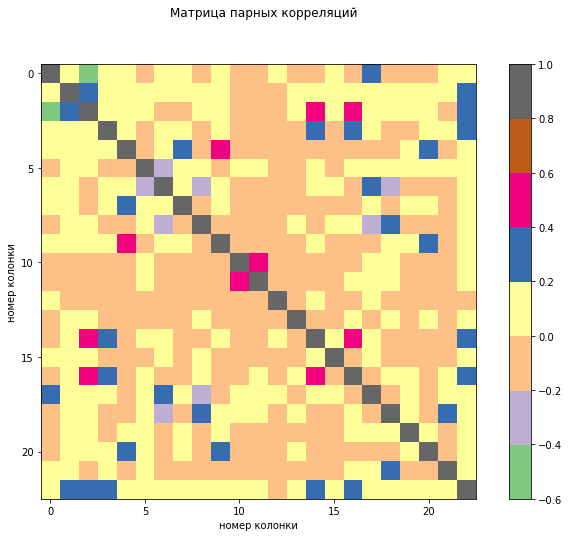

In [65]:
#расчет корреляционной матрицы и ее построение
matrix = uncorrelated_features.corr('pearson').to_numpy()
PlotCorrelationMatrix(matrix)

Как видно из рисунка избавление от сильнокоррелированых данных прошло успешно. Удалим сильнокоррелированные колонки из объединенного датасета `data_joined`.

In [66]:
#удаление колонок с сильной корреляцией
data_joined = data_joined.drop(uncorrelated_names, axis = 1)

#удаление колонки Wire 5
data_joined = data_joined.drop(['Wire 5', 'Wire 7'], axis = 1)

#вывод информации о датасете
data_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2311 entries, 1 to 2499
Data columns (total 24 columns):
Initial_T    2311 non-null float64
Final_T      2311 non-null float64
count        2311 non-null int64
heat_time    2311 non-null float64
Bulk 1       2311 non-null float64
Bulk 2       2311 non-null float64
Bulk 3       2311 non-null float64
Bulk 4       2311 non-null float64
Bulk 5       2311 non-null float64
Bulk 6       2311 non-null float64
Bulk 7       2311 non-null float64
Bulk 8       2311 non-null float64
Bulk 9       2311 non-null float64
Bulk 10      2311 non-null float64
Bulk 11      2311 non-null float64
Bulk 12      2311 non-null float64
Bulk 13      2311 non-null float64
Bulk 14      2311 non-null float64
Wire 1       2311 non-null float64
Wire 2       2311 non-null float64
Wire 3       2311 non-null float64
Wire 6       2311 non-null float64
Wire 9       2311 non-null float64
Газ 1        2311 non-null float64
dtypes: float64(23), int64(1)
memory usage: 451.4 KB


После удаления осталось только 23 колонки, а было 34.

#### Выделение обучающей, валидационной и тестовой  выборок

При построении моделей будем использовать кросс-валидацию, поэтому выделим только обучающую и тестовую выборки, валидационные выборки будем получать уже в ходе тренировки модели. 

In [67]:
#зададим значение псевдослучайного состояния
random = 12345

In [68]:
#разделение выборки на обучающую и тестовую
train, test = train_test_split(data_joined, test_size = 0.2, random_state = random)

In [69]:
#создание датасетов для обучающей выборки
train_features = train.drop('Final_T', axis = 1) #признаки
train_target = train['Final_T']  #целевые признаки    

In [70]:
#создание датасетов для тестовой выборки
test_features = test.drop('Final_T', axis = 1) #признаки
test_target = test['Final_T'] #целевые признаки 

In [71]:
#проверка датасета на содержание колонок только с нулевыми значениями
def ZerosCheck(data1, data2):
    
    #задание списков с колонками для удаления
    del_list = []
    del_list2 = []
    
    #проверка того, что все значения в колонки равны нулю
    for column in data1.columns:
        zeros_num = data1[column].eq(0).sum(axis = 0)
        zeros_num2 = data2[column].eq(0).sum(axis = 0)
        
        #формирование списков колонок на удаление
        if zeros_num == len(data1[column]):
            del_list.append(column)
            
        if zeros_num2 == len(data2[column]):
            del_list2.append(column)
            
    #удаление колонок из обоих датасетов (выборок) для обоих списков
    data1 = data1.drop(del_list, axis = 1)  #del_list
    data2 = data2.drop(del_list, axis = 1)
    
    data1 = data1.drop(del_list2, axis = 1)  #del_list2
    data2 = data2.drop(del_list2, axis = 1)
    
    return data1, data2, del_list, del_list2

In [72]:
#удаление колонок только с нулевыми значениями
train_features, test_features, list1, list2 = ZerosCheck(train_features, test_features)

print('Список колонок для удаления', list1, list2)

Список колонок для удаления [] ['Bulk 8']


In [73]:
#вывод числа признаков
print('Число признаков',train_features.shape[1])
print('Число признаков',test_features.shape[1])

Число признаков 22
Число признаков 22


Проверим совпадают ли распределения температуры для выборок. 

1. Нулеваяя гипотеза, H<sub>0</sub> - распределения температур для выборок (тренировочной и валидационной; тренировочной и тестовой) статистически одинаковы.
2. Альтернативная гипотеза, H<sub>1</sub> - распределения температур для выборок (тренировочной и валидационной; тренировочной и тестовой) статистически различны. 

In [74]:
#проверка Гипотезы для тренировочной и валидационной выборок
def StatTest(data1, data2, alpha_level):
    
    results = st.ttest_ind(data1, data2, equal_var = False)

    alpha = alpha_level  #задание уровня значимости

    p_value = results.pvalue
    print('p_value равна', p_value)


    if p_value > alpha:    
        print('Не отвергаем нулевую гипотезу, можно считать, что распределения статистически идентичны')
    else:
        print('Не принимаем нулевую гипотезу, можно считать, что распределения статистически различны')

In [75]:
#проверка гипотезы для тренировочной и тестовой выборок
StatTest(train_target, test_target, 0.01)

p_value равна 0.5167418688415015
Не отвергаем нулевую гипотезу, можно считать, что распределения статистически идентичны


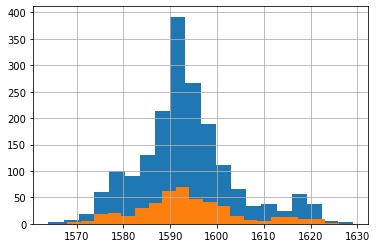

In [76]:
#построение гистограмм для температуры
train_target.hist(bins = 20);
test_target.hist(bins = 20);

Визуальное сравнение распределение температуры также говорит об их похожести друг на друга.

## Обучение модели

In [77]:
#игнорирование предупреждений
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Расчет метрики MAE для наивного регрессора

Расчет метрики MAE для наивного регрессора

In [78]:
#расчет предсказаний для среднего тестовой выборки
dummy_regr = DummyRegressor(strategy="mean")

#обучение
dummy_regr.fit(train_features, train_target)

#расчет предсказаний
predictions = dummy_regr.predict(test_features)

In [79]:
#расчет метрики MAE
MAE = mean_absolute_error(test_target, predictions)

print('MAE = ', MAE)

MAE =  8.369629650407193


In [80]:
#расчет метрики R2
R2 = r2_score(test_target, predictions)

print('R2 = ', R2)

R2 =  -0.00110885413724926


Отрицательное значений R2 указывает на крайне плохое попадание в пики. 

In [81]:
#задание значения MAE и R2 для наивной регрессии
dummy_MAE = MAE
dummy_R2 = R2

### Выбор оптимальной модели для предсказаний температуры

Для построения предсказательной модели будем использовать линейную регрессию, случайный лес и градиентный бустинг.

#### Анализ важности признаков (функции)

В этом разделе задаются функции для вывода на экран важности призанков и визуализации важности. 

In [82]:
#функция вывода отсортированного списка признаков по убыванию их важности
def ImportancePrint(importances, features_columns):
    
    #расчет важности признаков
    #importances = model.feature_importances_

    #сортировка индексов в соответствии с важностью признаков
    indices = np.argsort(importances)[::-1]

    #преобразования названий колонок в список 
    columns_list = features_columns.to_list()

    #вывод колонок по их важности
    for i in range(train_features.shape[1]):
        print('{}. {}, ({})'.format((i + 1), columns_list[indices[i]], importances[indices[i]]))
        
    return indices

In [83]:
#функция графического отображения важности признаков
def ImportanceGraph(features_columns, importances, indices):
    
    columns_order = []
    
    #построение графиков
    fig, axes = plt.subplots(1, 1, figsize=(16,8))
    plt.suptitle("Важность признаков")
    
    #преобразования названий колонок в список 
    columns_list = features_columns.to_list()
    
    for i in range(len(indices)):
        columns_order.append(columns_list[indices[i]])
           
    #построение столбчатой диаграммы
    axes.bar(columns_order, importances[indices], color="blue", align = "center", )
    
    axes.set_xticklabels(columns_order, rotation = 75)
    axes.set_xlim([-1, features.shape[1]])

In [84]:
#функция для сокращения числа признаков 
def FeaturesReduce(train, test, threshold, scores, indices):
    
    del_list = []
    
    for i in range(len(scores)):
        score = scores[indices[i]]
        column = train.columns.to_list()[indices[i]]
        
        if score < threshold:
            del_list.append(column)
    
    train = train.drop(del_list, axis = 1)
    test = test.drop(del_list, axis = 1)
    
    return train, test, del_list

#### Линейная регрессия

In [85]:
#задание модели
model = LinearRegression()
    
#обучение модели
model.fit(train_features, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
#расчет предсказаний
predictions = model.predict(test_features)

MAE = mean_absolute_error(test_target, predictions)
print('MAE = ', MAE)

MAE =  6.325519728953251


Значение метрики MAE у неоптимизированной линейной регрессии значительно лучше, чем у наивного регрессора.

In [87]:
# конфигурируем выбор признаков для регрессии
model = SelectKBest(score_func = f_regression, k = 'all')

# обучение модели
model.fit(train_features, train_target)

SelectKBest(k='all', score_func=<function f_regression at 0x7f100852cef0>)

In [88]:
#сортировка индексов в соответствии с важностью признаков
importances = model.scores_

indices = ImportancePrint(importances, train_features.columns)

1. Initial_T, (210.5797233559207)
2. Wire 1, (190.45715328485477)
3. heat_time, (151.44133058521868)
4. Bulk 12, (129.3624217257145)
5. Wire 2, (87.72783173080657)
6. Bulk 4, (87.62678264047854)
7. Bulk 6, (61.2765578345282)
8. count, (48.73221216974099)
9. Bulk 11, (26.219927042099023)
10. Bulk 14, (19.50218897705434)
11. Газ 1, (18.903037603770926)
12. Bulk 7, (4.480799214818884)
13. Bulk 3, (3.734831652111443)
14. Bulk 10, (2.9368492052814243)
15. Bulk 1, (2.8537388520910345)
16. Wire 9, (2.2342735905599467)
17. Wire 6, (1.9135776673625544)
18. Wire 3, (1.7046818854771326)
19. Bulk 9, (1.2661755151257037)
20. Bulk 2, (0.8003341426471814)
21. Bulk 13, (0.4520142460430437)
22. Bulk 5, (0.11898804760410572)


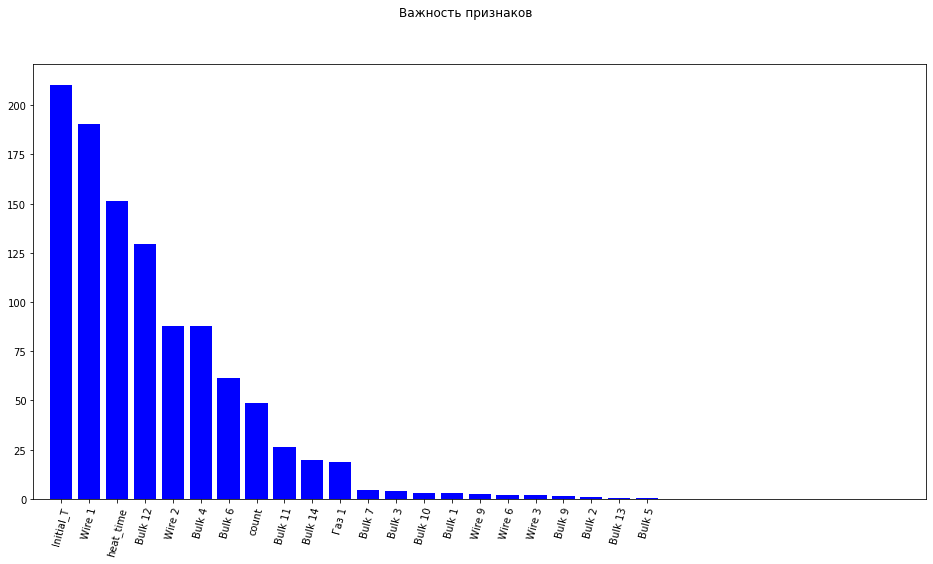

In [89]:
#построение столбчатой диаграммы
ImportanceGraph(train_features.columns, importances, indices)

Как видно из столбчатой диаграммы, самыми важными признаками являются: начальная температура (`Initial_T`) и объем добавок проволочных материалов (`Wire 1`). Третьим по важности параметров является длительность нагрева. И только четвертым идет добавление сыпучих примесей. 

In [90]:
#обновление набора признаков для обеих выборок
train_featuresLR, test_featuresLR, del_list = FeaturesReduce(train_features, test_features, \
                                                             5, importances, indices)

In [91]:
#вывод числа признаков
print('Число признаков',train_featuresLR.shape[1])
print('Число признаков',test_featuresLR.shape[1])

Число признаков 11
Число признаков 11


***Оптмизация модели на кросс-валидации***

In [92]:
linear_grid = {
    'normalize' : [True,False]
}

In [93]:
#задание модели пешающего дерева
model = LinearRegression()

#задание поиска оптимальных гиперпараметров
modelCV = GridSearchCV(estimator = model, scoring = 'neg_mean_absolute_error', 
                       param_grid = linear_grid, \
                       cv = 20, n_jobs = -1, verbose = 1)

In [94]:
#обучение модели
modelCV.fit(train_featuresLR, train_target)

Fitting 20 folds for each of 2 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished


GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=-1, param_grid={'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)

In [95]:
#сохранение наилучших гиперпараметров и параметров
best_params = modelCV.best_params_
#вывод значений гиперпараметров
print('Параметры модели')
print(best_params)

Параметры модели
{'normalize': True}


In [96]:
#вывод наилучшего значения метрики
score = modelCV.cv_results_['mean_test_score'][modelCV.best_index_]
print('MAE = ', (-1 * score))

MAE =  6.220612598819046


Значение метрики MAE на кросс-валидации лучше, чем неоптимизированной линейной регресии.

#### Случайный лес

In [97]:
#задание модели
model = RandomForestRegressor(n_estimators = 1000, max_depth = 10)

#обучение модели
model.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [98]:
#расчет предсказаний
predictions = model.predict(train_features)

#расчет значений метрик
MAE = mean_absolute_error(train_target, predictions)
R2 = r2_score(train_target, predictions)

#вывод результатов
print('MAE = ', MAE)
print('R2 = ', R2)

MAE =  3.4931207162523115
R2 =  0.8209278819370115


Случайный лес даже без оптимизации показал значительное улучшение метрики MAE. Крайне низкие значения MAE указывают на переобучение. Необходимо обучение модели на кросс-валидации.

In [99]:
#расчет важности признаков
importances = model.feature_importances_

#вывод важности признаков отсортированных в порядке убывания важности
indices = ImportancePrint(importances, test_features.columns)

1. heat_time, (0.2657542501477229)
2. Initial_T, (0.23962186489888274)
3. Wire 1, (0.10456753855263339)
4. Bulk 6, (0.08339284775415033)
5. Газ 1, (0.06229277280681912)
6. Bulk 12, (0.050411858585663494)
7. Wire 2, (0.047527327639284855)
8. Bulk 14, (0.04417593193046673)
9. count, (0.025296712825137964)
10. Bulk 3, (0.022212896007248822)
11. Bulk 4, (0.02141591197305401)
12. Bulk 1, (0.01444557454338277)
13. Bulk 11, (0.006510823253355043)
14. Bulk 10, (0.005404374906228743)
15. Wire 3, (0.002003625573530776)
16. Wire 6, (0.0019406604955591541)
17. Bulk 13, (0.0011895500084896998)
18. Bulk 5, (0.0010603981193713905)
19. Wire 9, (0.0004753844679667286)
20. Bulk 9, (0.000231289176094355)
21. Bulk 7, (4.2076973548084774e-05)
22. Bulk 2, (2.6329361409029038e-05)


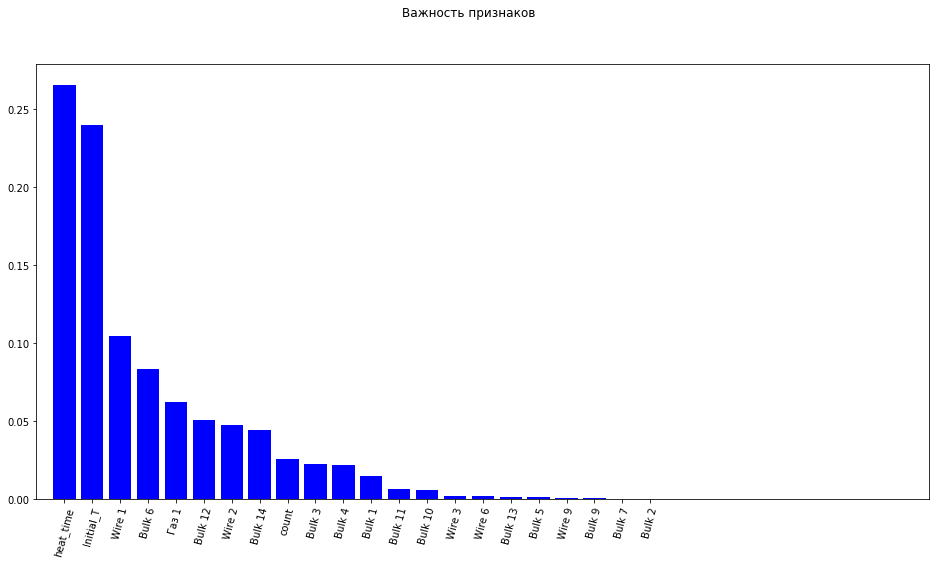

In [100]:
#графическое представление важности признаков
ImportanceGraph(test_features.columns, importances, indices)

Как видно из столбчатой диаграммы, самыми важными признаками являются: длительность нагрева, `heat_time` и начальная температура, `Initial_T`. При этом добавление примесей идет с большим отставанием по важности.

In [101]:
#обновление набора признаков для обеих выборок
train_featuresRF, test_featuresRF, del_list = FeaturesReduce(train_features, test_features, \
                                                             0.04, importances, indices)

In [102]:
#вывод числа признаков
print('Число признаков',train_featuresRF.shape[1])
print('Число признаков',test_featuresRF.shape[1])

Число признаков 8
Число признаков 8


***Оптмизация модели на кросс-валидации***

In [103]:
forest_grid = { 
              'n_estimators' : [200, 400, 1000],  
              'max_depth': [8, 10, 20],
              'min_samples_leaf' : [1, 2, 4],  
              'random_state' : [random]  
            }

In [104]:
#задание модели пешающего дерева
model = RandomForestRegressor()

#задание поиска оптимальных гиперпараметров
modelCV = GridSearchCV(estimator = model, param_grid = forest_grid, \
                          scoring = 'neg_mean_absolute_error', \
                          cv = 3, n_jobs = -1, verbose = 1)

In [105]:
#обучение модели
modelCV.fit(train_featuresRF, train_target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  4.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [8, 10, 20],
       

In [106]:
#сохранение наилучших гиперпараметров и параметров
best_params = modelCV.best_params_
best_model = modelCV.best_estimator_
best_score = modelCV.best_score_

#вывод значений гиперпараметров
print('Параметры модели')
print(best_params)

Параметры модели
{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 1000, 'random_state': 12345}


In [107]:
#вывод наилучшего значения метрики
score = modelCV.cv_results_['mean_test_score'][modelCV.best_index_]
print('MAE = ', (-1 * score))

MAE =  5.92056231577709


In [108]:
#расчет предсказаний
predictions = modelCV.predict(train_featuresRF)

#расчет метрики R2
R2 = r2_score(train_target, predictions)

#вывод значения метрики
print('R2 = ', R2)

R2 =  0.9217511808176455


Случайный лес показал значительное улучшение значения MAE на кросс-валидации и высокое значение R2 на тренировочной выборке. Однако надо учитывать, что на тренировочной выборке значение R2 упадет.

Сравним качество предсказаний с градиентным бустингом.

#### CatBoost

In [109]:
#создание тренировочного датасета
train_dataset = Pool(train_features, train_target)

In [110]:
catboost_params = {
    'iterations' : 400,
    'learning_rate' : 0.1,
    'depth' : 4,
    'random_seed' : random,
    'loss_function' : 'MAE',
    'boosting_type': 'Plain',
    'verbose' : 1000
}

In [111]:
#задание модели
model = cb.CatBoostRegressor(**catboost_params)

#обучение модели
model.fit(train_dataset)

0:	learn: 7.5685055	total: 51.5ms	remaining: 20.6s
399:	learn: 4.2010531	total: 4.58s	remaining: 0us


In [112]:
#расчет предсказаний
predictions = model.predict(train_features)

#расчет значений метрик
MAE = mean_absolute_error(train_target, predictions)
R2 = r2_score(train_target, predictions)

#вывод результатов
print('MAE = ', MAE)
print('R2 = ', R2)

MAE =  4.201054056082311
R2 =  0.6545980590590593


Крайне низкие значения MAE указывают на переобучение. Необходимо обучение модели на кросс-валидации.

In [113]:
#расчет важности признаков
importance_data = model.get_feature_importance(data = train_dataset, type = 'LossFunctionChange', 
                       prettified = True, thread_count = -1, verbose = 1000)

Used MAE metric for fstr calculation
Selected 1848 documents from 1848 for LossFunctionChange calculation.

Iteration with suspicious time 0.0684 sec ignored in overall statistics.
Started LossFunctionChange calculation
1848/1848 Process documents	passed time: 105ms	remaining time: 0us


In [114]:
#вывод важности признаков
importance_data

,Feature Id,Importances
0,heat_time,2.111777
1,Initial_T,1.861081
2,Wire 2,0.305754
3,Wire 1,0.302570
4,Bulk 6,0.289879
5,Bulk 14,0.208704
6,Bulk 12,0.202748
7,Газ 1,0.167697
8,Bulk 1,0.143964
9,Bulk 3,0.076308


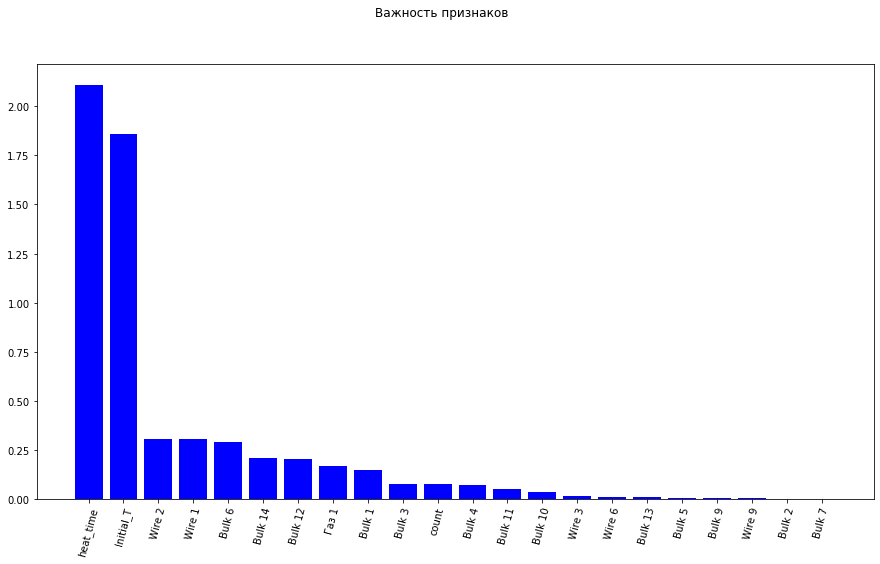

In [115]:
#построение столбчатой диаграммы
fig, axes = plt.subplots(1, 1, figsize=(15,8))
plt.suptitle("Важность признаков")
    
#построение столбчатой диаграммы
axes.bar(importance_data['Feature Id'], importance_data['Importances'], color="blue", align = "center", );
    
axes.set_xticklabels(importance_data['Feature Id'], rotation = 75);

Как видно из столбчатой диаграммы, для Catboost, как и для случайного леса наиболее важными параметрами являются начальная температура и время нагрева. 

In [116]:
#задание порога важности
threshold = 0.2

In [117]:
#обновление набора признаков для обеих выборок
del_list = []
    
#определение превышает ли критерий важности пороговое значение
for i in range(len(importance_data['Importances'])):
    score = importance_data.loc[i,'Importances']
    column = importance_data.loc[i,'Feature Id']
        
    #занесение в список колонок для удаления
    if score < threshold:
        del_list.append(column)

#сокращение числа признаков
train_featuresCB = train_features.drop(del_list, axis = 1)
test_featuresCB = test_features.drop(del_list, axis = 1)

In [118]:
#вывод списка колонок для исключения из числа признаков
del_list

['Газ 1',
 'Bulk 1',
 'Bulk 3',
 'count',
 'Bulk 4',
 'Bulk 11',
 'Bulk 10',
 'Wire 3',
 'Wire 6',
 'Bulk 13',
 'Bulk 5',
 'Bulk 9',
 'Wire 9',
 'Bulk 2',
 'Bulk 7']

In [119]:
#вывод числа признаков
print('Число признаков',train_featuresCB.shape[1])
print('Число признаков',test_featuresCB.shape[1])

Число признаков 7
Число признаков 7


In [120]:
#создание тренировочного датасета с сокращенным числом признаков
train_datasetCB = Pool(train_featuresCB, train_target)

***Тюнинг CatBoost***

In [121]:
#задание неизменяемых параметров при кросс-валидации
catboost_params = {
    'random_seed' : random,
    'loss_function' : 'MAE',
    'boosting_type': 'Plain', 
}

In [122]:
grid_params = {
    'depth': [2, 4, 6, 8],
    'iterations' : [100, 200, 400],
    'learning_rate': [0.1, 0.25, 0.5]
}

In [123]:
#задание модели 
model = cb.CatBoostRegressor(**catboost_params, logging_level='Silent')

#задание поиска оптимальных гиперпараметров
modelCV = GridSearchCV(estimator = model, param_grid = grid_params, \
                        scoring = 'neg_mean_absolute_error', \
                        cv = 3, n_jobs = -1, verbose = 1)

In [124]:
#обучение модели
modelCV.fit(train_featuresCB, train_target)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  9.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f1007fef990>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [100, 200, 400],
                         'learning_rate': [0.1, 0.25, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)

In [125]:
#сохранение наилучших гиперпараметров и параметров
best_params = modelCV.best_params_
best_model = modelCV.best_estimator_
best_score = modelCV.best_score_

#вывод значений гиперпараметров
print('Параметры модели')
print(best_params)

Параметры модели
{'depth': 2, 'iterations': 200, 'learning_rate': 0.1}


In [126]:
#вывод наилучшего значения метрики
score = modelCV.cv_results_['mean_test_score'][modelCV.best_index_]
print('MAE = ', (-1 * score))

MAE =  5.920691831389531


CatBoost позволил добиться меньшего значения MAE, чем RandomForest.

In [127]:
#расчет предсказаний
predictions = modelCV.predict(train_featuresCB)

#расчет метрики R2
R2 = r2_score(train_target, predictions)

#вывод значения метрики
print('R2 = ', R2)

R2 =  0.49139168578520187


Значение R2 на тренировочной выборке весьма высокое.

### Расчет метрики MAE и R2 для наилучшей модели на тестовой выборке

Сравним значения метрик MAE и R2 на тестовой выборке для моделей случайного леса и CatBoost.

In [128]:
#линейнай регрессия
linear_reg = {
    'normalize' : [False]
}

#случайный лес
random_forest = {
    'n_estimators' : [1000],  
    'max_depth': [10],
    'min_samples_leaf' : [4],
    'random_state' : [random]  
}

catboost = {
    'boosting_type': 'Plain',
    'loss_function' : 'MAE',
    'verbose' : 1000,
    'random_seed' : random
}

grid_paramsCV = {
    'depth': [4],
    'iterations' : [400],
    'learning_rate': [0.1]
}

In [129]:
#задание индексов - названий моделей
pivot_data_index = ['LinearReg', 'RandForest', 'CatBoost']

#задание колонок
pivot_data_columns = ['fit_time', 'MAE', 'R2']

#задание сводной таблицы
pivot_data = pd.DataFrame(np.zeros((3, 3)), \
                          index = pivot_data_index, \
                          columns = pivot_data_columns)

pivot_data

,fit_time,MAE,R2
LinearReg,0.0,0.0,0.0
RandForest,0.0,0.0,0.0
CatBoost,0.0,0.0,0.0


In [130]:
#задание моделей
modelLR = LinearRegression()                     #линейная регрессия

modelRF = RandomForestRegressor()                #случайный лес

modelCB = cb.CatBoostRegressor(**catboost)       #CatBoost

#### Линейная регрессия

In [131]:
#задание модели на кросс-валидации
modelLRCV = GridSearchCV(estimator = modelLR, scoring = 'neg_mean_squared_error', 
                       param_grid = linear_reg, \
                       cv = 3, n_jobs = -1, verbose = 1)

In [132]:
#обучение модели
result = %timeit -n1 -r1 -o modelLRCV.fit(train_featuresLR, train_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
71.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [133]:
#расчет предсказаний
predictionsLR = modelLRCV.predict(test_featuresLR)

#расчет метрик
LR_MAE = mean_absolute_error(test_target, predictionsLR)
LR_R2 = r2_score(test_target, predictionsLR)

In [134]:
#занесение данных в таблицу
pivot_data.loc['LinearReg', 'fit_time'] = round(result.all_runs[0],3)
pivot_data.loc['LinearReg', 'MAE'] = round(LR_MAE,3)
pivot_data.loc['LinearReg', 'R2'] = round(LR_R2,3)

#### Случайный лес

In [135]:
#задание модели Случайного Леса на кросс-валидации
modelRFCV = GridSearchCV(estimator = modelRF, scoring = 'neg_mean_absolute_error', 
                       param_grid = random_forest, \
                       cv = 3, n_jobs = -1, verbose = 1)

In [136]:
#обучение модели
result = %timeit -n1 -r1 -o modelRFCV.fit(train_featuresRF, train_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s finished


21.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [137]:
#расчет предсказаний
predictionsRF = modelRFCV.predict(test_featuresRF)

#расчет метрик
RF_MAE = mean_absolute_error(test_target, predictionsRF)
RF_R2 = r2_score(test_target, predictionsRF)

In [138]:
#занесение данных в таблицу
pivot_data.loc['RandForest', 'fit_time'] = round(result.all_runs[0],3)
pivot_data.loc['RandForest', 'MAE'] = round(RF_MAE,3)
pivot_data.loc['RandForest', 'R2'] = round(RF_R2,3)

#### CatBoost

In [139]:
#задание модели Случайного Леса на кросс-валидации
modelCBCV = GridSearchCV(estimator = modelCB, scoring = 'neg_mean_absolute_error', 
                       param_grid = grid_paramsCV, \
                       cv = 3, n_jobs = -1, verbose = 1)

In [140]:
#обучение модели
result = %timeit -n1 -r1 -o modelCBCV.fit(train_featuresCB, train_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 7.3759730	total: 2.9ms	remaining: 1.16s
399:	learn: 4.0512976	total: 4.44s	remaining: 0us
0:	learn: 7.6863626	total: 3.63ms	remaining: 1.45s
399:	learn: 4.0896087	total: 4.52s	remaining: 0us
0:	learn: 7.7288139	total: 1.14ms	remaining: 457ms
399:	learn: 4.2958221	total: 4.49s	remaining: 0us


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.2s finished


0:	learn: 7.5975098	total: 1.59ms	remaining: 635ms
399:	learn: 4.4700494	total: 4.44s	remaining: 0us
25.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [141]:
#расчет предсказаний
predictionsCB = modelCBCV.predict(test_featuresCB)

#расчет метрик
CB_MAE = mean_absolute_error(test_target, predictionsCB)
CB_R2 = r2_score(test_target, predictionsCB)

In [142]:
#занесение данных в таблицу
pivot_data.loc['CatBoost', 'fit_time'] = round(result.all_runs[0],3)
pivot_data.loc['CatBoost', 'MAE'] = round(CB_MAE,3)
pivot_data.loc['CatBoost', 'R2'] = round(CB_R2,3)

### Анализ результатов для наилучшей модели

#### Анализ результатов

In [143]:
#вывод сводной таблицы
pivot_data

,fit_time,MAE,R2
LinearReg,0.071,6.248,0.442
RandForest,21.449,5.922,0.503
CatBoost,25.496,5.802,0.511


Как видно из сводной таблицы наилучшее (наименьшее) значение метрик MAE = 5.802 и R2 = 0.511 достигаются с помощью модели CatBoost. Отметим, что все три использованные модели имеют достаточно близкие значения MAE, т.е нет модели, которая была бы существенно хуже, чем остальные. В итоге, остановимся на модели CatBoost, поскольку она дает наименьшее значение MAE.

#### Подготовка данных для отчета заказчику

Рассчитаем ошибку предсказания по отношению к разности конечной и начальной температур.

In [144]:
comparison_data = pd.DataFrame(index = test_target.index, \
                               columns = ['predictions', 'target', 'initial'])

#задание предсказаний и тестовых значений
comparison_data['predictions'] = predictionsCB
comparison_data['target'] = test_target

#задание начальной температуры
comparison_data['initial'] = test_features['Initial_T']

In [145]:
#создание сводной таблицы для подсчета амплитуды изменения температуры
data_temp3 = data_temp2.pivot_table(values = 'Температура', index = 'key', \
                                    aggfunc = ['max', 'min'])

#переименование колонок
data_temp3.columns = ['max', 'min']
data_temp3 = data_temp3.reset_index()

data_temp3['T_difference'] = data_temp3['max'] - data_temp3['min']
data_temp3

,key,max,min,T_difference
0,1,1618.0,1571.0,47.0
1,2,1608.0,1577.0,31.0
2,3,1599.0,1596.0,3.0
3,4,1625.0,1601.0,24.0
4,5,1602.0,1576.0,26.0
...,...,...,...,...
3211,3237,1569.0,1569.0,0.0
3212,3238,1584.0,1584.0,0.0
3213,3239,1598.0,1598.0,0.0
3214,3240,1617.0,1617.0,0.0


In [146]:
comparison_data = comparison_data.merge(data_temp3, on = 'key', how ='inner')

comparison_data = comparison_data.set_index('key').sort_index(axis = 0)

In [147]:
#подсет ошибки предсказания отнесенной к разности конечной и начальной температур
comparison_data['relative_error_range'] = 100 * \
                                    (comparison_data['predictions'] - comparison_data['target'])/\
                                    comparison_data['T_difference']

In [148]:
#расчет относительной ошибки предсказания 
comparison_data['relative_error'] = 100 * \
                                    (comparison_data['predictions'] - comparison_data['target'])/\
                                    comparison_data['target']

In [149]:
#расчет R2 для каждого измерения
comparison_data['r2_key'] = 1 - \
                            (comparison_data['predictions'] - comparison_data['target'])**2/\
                            (comparison_data['target'] - comparison_data['target'].mean())**2                

In [150]:
#вывод данных
comparison_data

,predictions,target,initial,max,min,T_difference,relative_error_range,relative_error,r2_key
key,,,,,,,,,
1,1597.841984,1613.0,1571.0,1618.0,1571.0,47.0,-32.251098,-0.939741,0.380962
2,1595.671894,1602.0,1581.0,1608.0,1577.0,31.0,-20.413247,-0.395013,0.413872
4,1597.241756,1625.0,1601.0,1625.0,1601.0,24.0,-115.659352,-1.708200,0.211778
9,1591.451281,1592.0,1587.0,1597.0,1587.0,10.0,-5.487194,-0.034467,0.899901
10,1590.230911,1593.0,1574.0,1593.0,1574.0,19.0,-14.574151,-0.173829,-13.219289
...,...,...,...,...,...,...,...,...,...
2488,1590.280195,1577.0,1602.0,1602.0,1573.0,29.0,45.793777,0.842118,0.370216
2489,1584.096133,1579.0,1613.0,1613.0,1574.0,39.0,13.067009,0.322744,0.880375
2490,1607.422024,1619.0,1602.0,1630.0,1599.0,31.0,-37.348311,-0.715131,0.790007


In [151]:
#построение датасетов с ращличным числом признаков
def FeaturesSelect(train, test, threshold):
    
    #обновление набора признаков для обеих выборок
    del_list = []
    
    #определение превышает ли критерий важности пороговое значение
    for i in range(len(importance_data['Importances'])):
        score = importance_data.loc[i,'Importances']
        column = importance_data.loc[i,'Feature Id']
        
        #занесение в список колонок для удаления
        if score < threshold:
            del_list.append(column)

    #сокращение числа признаков
    train = train_features.drop(del_list, axis = 1)
    test = test_features.drop(del_list, axis = 1)
    
    #селекция признаков
    listSelect = train.columns.to_list()
    data = importance_data[importance_data['Feature Id'].isin(listSelect)]
           
    return train, test, data

In [152]:
def CalcFMetrics(train, train_target, test, test_target):
   
    #задание модели Случайного Леса на кросс-валидации
    modelCBCV = GridSearchCV(estimator = modelCB, scoring = 'neg_mean_absolute_error', 
                       param_grid = grid_paramsCV, \
                       cv = 3, n_jobs = -1, verbose = 1)
    
    #обучение модели
    modelCBCV.fit(train, train_target)

    #расчет предсказаний
    predictionsCB = modelCBCV.predict(test)

    #расчет метрик
    MAE = mean_absolute_error(test_target, predictionsCB)
    R2 = r2_score(test_target, predictionsCB)
    
    columns_list = train.columns.to_list()
    
    return MAE, R2, columns_list

In [153]:
#создание списка датасетов с тремя наборами признаков
train1, test1, data1 = FeaturesSelect(train_features, test_features, 0.2)
train2, test2, data2 = FeaturesSelect(train_features, test_features, 0.25)
train3, test3, data3 = FeaturesSelect(train_features, test_features, 1.0)

In [154]:
#обучение модели на трех датасетах с разным числом признаков
MAE1, R21, list1 =  CalcFMetrics(train1, train_target, test1, test_target)
MAE2, R22, list2 =  CalcFMetrics(train2, train_target, test2, test_target)
MAE3, R23, list3 =  CalcFMetrics(train3, train_target, test3, test_target)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 7.3759730	total: 1.15ms	remaining: 457ms
399:	learn: 4.0512976	total: 4.57s	remaining: 0us
0:	learn: 7.6863626	total: 1.82ms	remaining: 726ms
399:	learn: 4.0896087	total: 4.77s	remaining: 0us
0:	learn: 7.7288139	total: 1.87ms	remaining: 746ms
399:	learn: 4.2958221	total: 4.92s	remaining: 0us


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s finished


0:	learn: 7.5975098	total: 1.42ms	remaining: 567ms
399:	learn: 4.4700494	total: 5.4s	remaining: 0us
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 7.3198042	total: 8.84ms	remaining: 3.53s
399:	learn: 4.3647445	total: 4.3s	remaining: 0us
0:	learn: 7.6288139	total: 2.49ms	remaining: 993ms
399:	learn: 4.4098671	total: 3.86s	remaining: 0us
0:	learn: 7.7288951	total: 1.24ms	remaining: 496ms
399:	learn: 4.4759419	total: 4.47s	remaining: 0us


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.6s finished


0:	learn: 7.5490250	total: 1.47ms	remaining: 587ms
399:	learn: 4.7499938	total: 4.89s	remaining: 0us
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 7.3219957	total: 1.52ms	remaining: 609ms
399:	learn: 5.1651198	total: 4.08s	remaining: 0us
0:	learn: 7.6381484	total: 3.03ms	remaining: 1.21s
399:	learn: 5.4715457	total: 4.02s	remaining: 0us
0:	learn: 7.7314113	total: 1.16ms	remaining: 464ms
399:	learn: 5.6168920	total: 3.95s	remaining: 0us


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s finished


0:	learn: 7.5516224	total: 2.16ms	remaining: 862ms
399:	learn: 5.6431483	total: 4.39s	remaining: 0us


## Отчет (модель)

### Представление результатов

*Финальные параметры предсказательной модели*  
Модель предсказания **CatBoost**  
*MAE* = 5.802   
*R2* = 0.511  

`boosting_type`: *Plain*,  
`depth`: 4,  
`iterations` : 400,  
`learning_rate`: 0.1  

Число признаков: 7

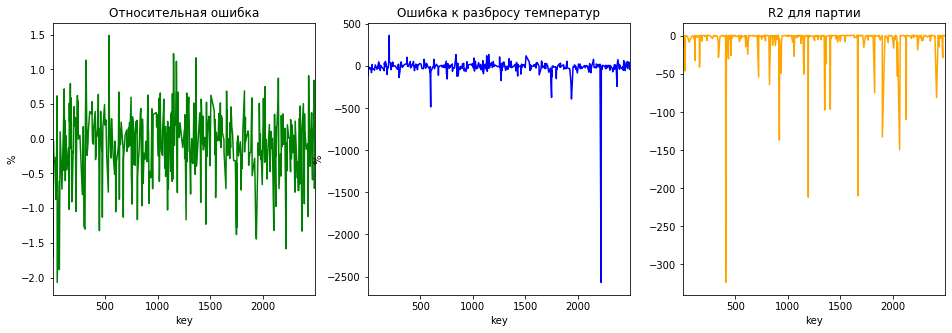

In [155]:
#построение графиков
fig, axes = plt.subplots(1,3, figsize = (16,5))

comparison_data['relative_error'].plot(color = 'green', ax = axes[0]);
comparison_data['relative_error_range'].plot(color = 'blue', ax = axes[1]);
comparison_data['r2_key'].plot(color = 'orange', ax = axes[2]);


#задание осей и подписей к рисункам
axes[0].set_ylabel('%');
axes[0].set_title('Относительная ошибка');

axes[1].set_ylabel('%');
axes[1].set_title('Ошибка к разбросу температур');

#axes[1].set_ylabel('%');
axes[2].set_title('R2 для партии');

Из графиков видно, что относительная ошибка предсказания температуры практически всегда меньше двух процентов. Ошибка предсказания отнесенная к разбросу температур в ходе процесса выплавки указывает насколько точно мы попадаем в диапазон изменения температуры в ходе выплавки, т.е. выходит или нет ошибка предсказания за диапазон изменения температуры в ходе роста. Если значение этой ошибки более 100 процентов, то это означает, что предсказательная модель не позволяет контролировать температуру, даже, если относительная ошибка предсказания для заданной температуры очень мала. 

In [156]:
#расчет числа предсказаний лежащих вблизи истинного значения
len_2 = comparison_data.loc[abs(comparison_data.loc[:,'relative_error']) < 2]

print('Процент предсказаний отличающихся от истинной температуры менее чем на два процента:')
print('{:.1%}'.format(len(len_2) / len(comparison_data)))

Процент предсказаний отличающихся от истинной температуры менее чем на два процента:
99.8%


In [157]:
#расчет числа предсказаний лежащих в диапазоне изменения температур
len_range = comparison_data.loc[abs(comparison_data.loc[:,'relative_error_range']) < 100]
len_range_50 = comparison_data.loc[abs(comparison_data.loc[:,'relative_error_range']) < 50]

print('Процент предсказаний в диапазон изменения температуры:')
print('{:.1%}'.format(len(len_range) / len(comparison_data)))

print('Процент предсказаний в полу-диапазон изменения температуры:')
print('{:.1%}'.format(len(len_range_50) / len(comparison_data)))

Процент предсказаний в диапазон изменения температуры:
94.8%
Процент предсказаний в полу-диапазон изменения температуры:
82.9%


In [158]:
#расчет числа предсказаний с R2 от 0.25 до 1
len_r2_025 = comparison_data.loc[(comparison_data.loc[:,'r2_key'] <= 1.0) &\
                             (comparison_data.loc[:,'r2_key'] >= 0.25)]
len_r2_05 = comparison_data.loc[(comparison_data.loc[:,'r2_key'] <= 1.0) &\
                             (comparison_data.loc[:,'r2_key'] >= 0.5)]


print('Процент предсказаний c r2 в диапазоне от 0.25 до 1:')
print('{:.1%}'.format(len(len_r2_025) / len(comparison_data)))

print('Процент предсказаний c r2 в диапазоне от 0.5 до 1:')
print('{:.1%}'.format(len(len_r2_05) / len(comparison_data)))

Процент предсказаний c r2 в диапазоне от 0.25 до 1:
54.6%
Процент предсказаний c r2 в диапазоне от 0.5 до 1:
45.6%


Полученные значения числа отклонений предсказаний указывает на хорошую предсказательную силу модели, однако, существуют ряд значению имеющих аномально большие отклонения предсказаний и истинных значений. Эти аномалии могут быть устранены путем более детального сбора статистики. 

Не все признаки имеют равную важность при предсказании температуры, однако исключение каких-то признаков может привести к ухудшению предсказательной мощности модели. 

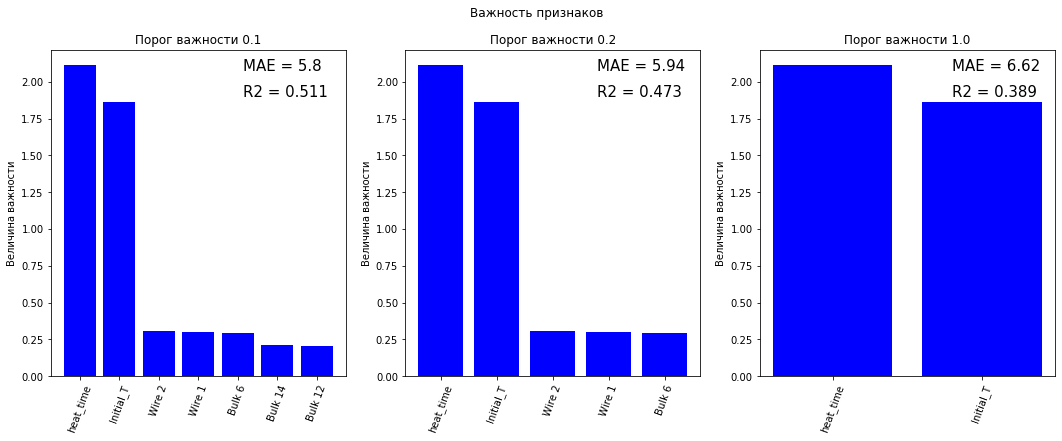

In [159]:
#построение графиков
fig, axes = plt.subplots(1,3, figsize = (18,6))

fig.suptitle("Важность признаков")
    
#построение столбчатой диаграммы
axes[0].bar(data1['Feature Id'], data1['Importances'], color="blue", align = "center");
axes[1].bar(data2['Feature Id'], data2['Importances'], color="blue", align = "center");
axes[2].bar(data3['Feature Id'], data3['Importances'], color="blue", align = "center");

#поворот подписей
axes[0].set_xticklabels(data1['Feature Id'], rotation = 70);
axes[1].set_xticklabels(data2['Feature Id'], rotation = 70);
axes[2].set_xticklabels(data3['Feature Id'], rotation = 70);

#задание осей и подписей к рисункам
axes[0].set_ylabel('Величина важности');
axes[1].set_ylabel('Величина важности');
axes[2].set_ylabel('Величина важности');

axes[0].set_title('Порог важности 0.1');
axes[1].set_title('Порог важности 0.2');
axes[2].set_title('Порог важности 1.0');

#вывод значений метрик
axes[0].text(0.65, 0.95, 'MAE = {:.3}'.format(MAE1), ha='left', va='center', size = 15, \
            transform = axes[0].transAxes);
axes[0].text(0.65, 0.87, 'R2 = {:.3}'.format(R21), ha='left', va='center', size = 15, \
            transform = axes[0].transAxes);
axes[1].text(0.65, 0.95, 'MAE = {:.3}'.format(MAE2), ha='left', va='center', size = 15, \
            transform = axes[1].transAxes);
axes[1].text(0.65, 0.87, 'R2 = {:.3}'.format(R22), ha='left', va='center', size = 15, \
            transform = axes[1].transAxes);
axes[2].text(0.65, 0.95, 'MAE = {:.3}'.format(MAE3), ha='left', va='center', size = 15, \
            transform = axes[2].transAxes);
axes[2].text(0.65, 0.87, 'R2 = {:.3}'.format(R23), ha='left', va='center', size = 15, \
            transform = axes[2].transAxes);

Из представленных столбчатых диаграмм видно, какие признаки важны и как меняются величины метрик при выборе различного числа признаков. Видно, что ключевыми признаками являются время нагрева и начальная температура. Именно эти параметры необходимо отслеживать в ходе процесса выплавки в первую очередь. Однако пренебрежение объемом примесей, добавляемых к расплаву, может привести к ухудшению предсказаний, т.е. к перерасходу энергии на нагрев расплава, а значит и к финансовым затратам.

Подводя итоги можно заключить, что: 
* построена модель, достаточно хорошо предсказывающая температуру расплава в конце процесса;
* установлены ключевые характеристики, которые необходимо отслеживать в процессе выплавки: время нагрева и начальную температуры;
* для хорошего предсказания конечной температуры недостаточно только величин начальной температуры и времени нагрева;
* для улучшения предсказаний температуры необходимо собрать дополнительную статистику.

### Подготовка данных к финальному отчету

In [160]:
#вывод данных об ошибках предсказаний
def ReportErrors():
    
    #построение графиков
    fig, axes = plt.subplots(1,3, figsize = (16,5))

    comparison_data['relative_error'].plot(color = 'green', ax = axes[0]);
    comparison_data['relative_error_range'].plot(color = 'blue', ax = axes[1]);
    comparison_data['r2_key'].plot(color = 'orange', ax = axes[2]);


    #задание осей и подписей к рисункам
    axes[0].set_ylabel('%');
    axes[0].set_title('Относительная ошибка');

    axes[1].set_ylabel('%');
    axes[1].set_title('Ошибка к разбросу температур');

    axes[2].set_title('R2 для партии');

In [161]:
#вывод данных о важности признаков
def ReportImportances():

    #построение графиков
    fig, axes = plt.subplots(1,3, figsize = (18,6))

    fig.suptitle("Важность признаков")
    
    #построение столбчатой диаграммы
    axes[0].bar(data1['Feature Id'], data1['Importances'], color="blue", align = "center");
    axes[1].bar(data2['Feature Id'], data2['Importances'], color="blue", align = "center");
    axes[2].bar(data3['Feature Id'], data3['Importances'], color="blue", align = "center");

    #поворот подписей
    axes[0].set_xticklabels(data1['Feature Id'], rotation = 70);
    axes[1].set_xticklabels(data2['Feature Id'], rotation = 70);
    axes[2].set_xticklabels(data3['Feature Id'], rotation = 70);

    #задание осей и подписей к рисункам
    axes[0].set_ylabel('Величина важности');
    axes[1].set_ylabel('Величина важности');
    axes[2].set_ylabel('Величина важности');

    axes[0].set_title('Порог важности 0.1');
    axes[1].set_title('Порог важности 0.2');
    axes[2].set_title('Порог важности 1.0');

    #вывод значений метрик
    axes[0].text(0.65, 0.95, 'MAE = {:.3}'.format(MAE1), ha='left', va='center', size = 15, \
                transform = axes[0].transAxes);
    axes[0].text(0.65, 0.87, 'R2 = {:.3}'.format(R21), ha='left', va='center', size = 15, \
                transform = axes[0].transAxes);
    axes[1].text(0.65, 0.95, 'MAE = {:.3}'.format(MAE2), ha='left', va='center', size = 15, \
                transform = axes[1].transAxes);
    axes[1].text(0.65, 0.87, 'R2 = {:.3}'.format(R22), ha='left', va='center', size = 15, \
                transform = axes[1].transAxes);
    axes[2].text(0.65, 0.95, 'MAE = {:.3}'.format(MAE3), ha='left', va='center', size = 15, \
                transform = axes[2].transAxes);
    axes[2].text(0.65, 0.87, 'R2 = {:.3}'.format(R23), ha='left', va='center', size = 15, \
                transform = axes[2].transAxes);

In [163]:
def ReportDistributionsT():
    #построение гистограмм для температуры
    train_target.hist(bins = 20);
    test_target.hist(bins = 20);

# Отчет по проекту <a class="tocSkip">

Основные этапы работы по проекту включали в себя:
* импорт данных;
* подготовка данных для модели;
* апробирование различных моделей и выбор наилучшей;
* применение модели для предсказания температуры для тестовой выборки;
* расчет метрик для характеризации качества модели на тестовой выборке;
* анализ полученных результатов.

## Подготовка данных <a class="tocSkip">

Перед обучением предсказательной модели была проведена обработка данных. Она включала в себя следующие этапы.

*Обработка пропусков*  
* замена пропусков на нулевые значения в данных об объеме сыпучих и проволочных материалов
`data_bulk`, `data_wire`;
* удаление пропусков в данных о температуре `data_temp`


*Отбрасывание излишних данных*
* исключение данных, содержащих информацию о дате и времени ввода сыпучих и проволочных материалов, `data_bulk_time`, `data_wire_time`

*Генерирование новых признаков*
* суммарное время нагрева (в сек.);
* полная затраченная энергия, рассчитываемая из полной мощности и суммарного времени нагрева;
* активная энергия (получаемая из активной мощности и времени нагрева);
* реактивная энергия (получаемая из реактивной мощности и времени нагрева);
* начальная температура расплава;
* количество засыпей сыпучих материалов;
* количество засыпей проволочных материалов

*Генерирование целевого признака*
* конечной температуры

*Анализ выбросов в данных по температуре*
* удаление экстремальных выборосов температуры (данные за пределамми $Q_{1}$ - $3\cdot IQR$ и $Q_{3}$ + $3\cdot IQR$);
* удаление экстремальных разностей конечной и начальной температур (если разность больше 400С)

*Объединение данных*
* объединение данных в единый датасет по номеру партии `key`

*Исследование мультиколлинеарности признаков*
* проверка корреляций между признаками;
* удаление сильнокоррелированных признаков (для которых коэффициент парной корреляции больше 0.6)

*Разделение данных на выборки*
* выделение тренировочной и обучающей выборок в пропорции 80:20;
* проверка наличия в полученных выборках признаков содержащих только нулевые значения и удаление таких признаков;
* проверка являются ли распределения финальной температуры в обучающей и тестовой выборках статистически одинаковыми

## Обучение модели <a class="tocSkip">

В проекте тестировались три модели: линейная регрессия, случайный лес и CatBoost. 

Качество модели оценивалось по метрике MAE, дополнительно вычислялась метрика R2. В качестве референсного значения служили значения метрик для наивного регрессора со стратегией предсказания средним значением. 

Исследование каждой из моделей состояло из следующих этапов. 

*Первичный анализ* 
* обучение модели с некоторыми начальными параметрами;
* расчетом метрик и сравнение с референсными значениями;
* ручное варьирование параметров для улучшения значений метрик (при необходимости)

*Анализ важности признаков*
* расчет важности признаков для модели обученной на этапе первичного анализа;
* отбрасывание маловажных признаков;
* генерирование нового набора данных для обучения, включающего только важные параметры

*Тюнинг модели на кросс-валидации*
* варьирование гиперпараметров модели на кросс-валидации (CV = 3)
* расчет метрик качества

*Расчет значений метрик на тестовой выборке*
* расчет метрик на тестовой выборке на кросс-валидации
* сравнение значений метрик моделей

## Отчет (модель) <a class="tocSkip">

На этом этапе: 
* в явном виде записаны параметры модели;
* произведена визуализация ошибок предсказаний
* графически представлена важность различных признаков.

## Финальные данные <a class="tocSkip">

### Набор данных <a class="tocSkip">

In [164]:
#вывод финального набора данных (обучающая выборка)
train_featuresCB

,Initial_T,heat_time,Bulk 6,Bulk 12,Bulk 14,Wire 1,Wire 2
key,,,,,,,
1089,1569.0,1080.716125,0.0,0.0,0.0,90.089996,0.000000
536,1629.0,106.821686,0.0,0.0,147.0,97.203606,14.145040
2380,1573.0,718.503162,107.0,136.0,148.0,90.155517,0.000000
1729,1635.0,149.641521,0.0,186.0,139.0,103.053604,0.000000
2004,1579.0,642.118334,0.0,222.0,120.0,118.110718,0.000000
...,...,...,...,...,...,...,...
2321,1565.0,2391.377253,0.0,402.0,115.0,99.197273,0.000000
595,1614.0,771.213721,0.0,397.0,225.0,140.166001,0.000000
428,1578.0,664.968766,0.0,264.0,137.0,140.680799,0.000000


In [165]:
#вывод финального набора данных (тренировочная выборка)
test_featuresCB

,Initial_T,heat_time,Bulk 6,Bulk 12,Bulk 14,Wire 1,Wire 2
key,,,,,,,
2146,1592.0,857.272184,62.0,205.0,176.0,84.127678,0.000000
618,1557.0,877.768045,0.0,0.0,0.0,70.199997,0.000000
1406,1606.0,509.393254,0.0,205.0,133.0,49.139999,0.000000
1693,1590.0,272.350219,193.0,187.0,128.0,135.673203,60.289841
608,1597.0,785.801220,0.0,104.0,154.0,60.091198,0.000000
...,...,...,...,...,...,...,...
2488,1602.0,388.744561,0.0,157.0,140.0,13.104000,37.066639
1101,1590.0,751.800651,115.0,206.0,141.0,116.110802,19.151600
2396,1618.0,698.453579,0.0,103.0,91.0,120.076317,32.361679


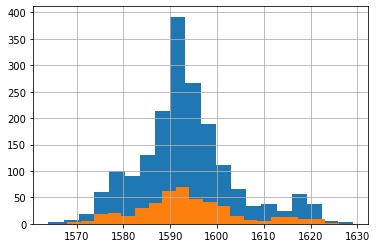

In [166]:
#распределения температур
ReportDistributionsT()

### Предсказательная модель <a class="tocSkip">

***CatBoost***

*Параметры модели*  

`boosting_type` : Plain  
`depth`         : 4  
`iterations`    : 400  
`learning_rate` : 0.1  
`loss_function` : MAE  

*Значения метрик*  

`MAE`: 5.802   
`R2`: 0.511  

*Сравнение метрик для разных моделей*

In [167]:
#вывод сводной таблицы
pivot_data

,fit_time,MAE,R2
LinearReg,0.071,6.248,0.442
RandForest,21.449,5.922,0.503
CatBoost,25.496,5.802,0.511


### Анализ ошибок предсказаний <a class="tocSkip">

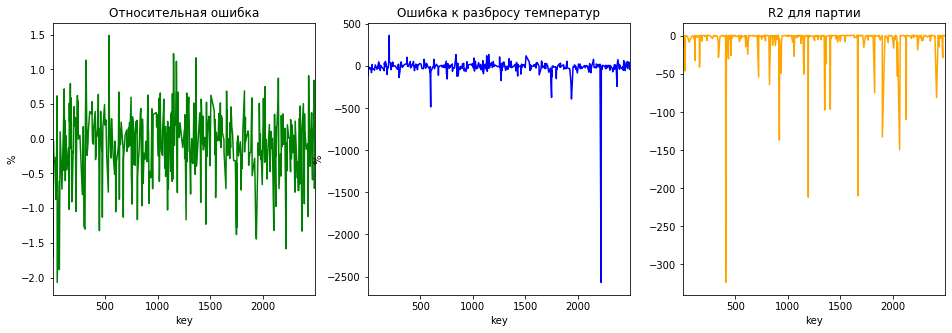

In [168]:
#вывод графиков
ReportErrors()

*Относительная ошибка*

Процент предсказаний отличающихся от истинной температуры менее чем на два процента: 99.8%

*Ошибка к разбросу температуры*

Процент предсказаний в диапазоне изменения температуры: 94.8%
Процент предсказаний в полу-диапазоне изменения температуры: 82.9%

*R2 для партии*

Процент предсказаний c R2 в диапазоне от 0.25 до 1: 54.6%
Процент предсказаний c R2 в диапазоне от 0.5 до 1: 45.6%

### Важность признаков <a class="tocSkip">

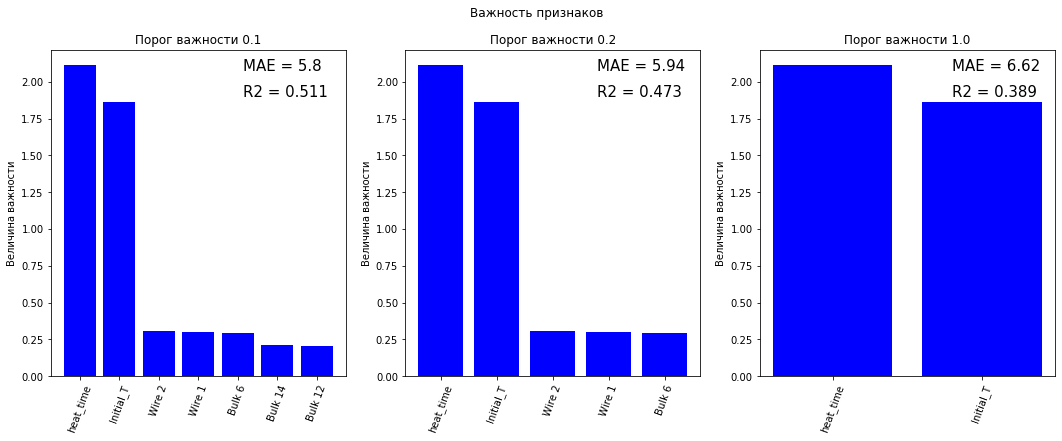

In [169]:
#вывод графиков
ReportImportances()

Ключевые параметры (признаки): 

* время нагрева (`heat_time`);
* начальная температура (`Initial_T`)

Необходимо учитывать:
* объем добавляемых проволочных материалов (`Wire 2`, `Wire 1`);
* объем добавляемых сыпучих материалов (`Bulk 6`, `Bulk 14`, `Bulk 12`)